### Import necessary libraries

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install nltk

In [55]:
import numpy as np
import pandas as pd
import nltk
import re
import ast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Data Preparation Stage

### Data Exploration

#### Read the data from dataset (news.csv)

In [3]:
#Code and news.csv source from https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

#DataFlair - Read the data
df=pd.read_csv('news.csv')
#DataFlair - Get shape and head
df.head()

#If baseline dataset and clean data has been created, read them instead
#Function to read local csv
def read_csv(filepath):
    df = pd.read_csv(filepath)
    df['title'] = df['title']
    df['text'] = df['text']
    return df
#baseline_df=read_csv('baseline_news.csv')    
#clean_df=read_csv('clean_news.csv')

In [4]:
df.shape

(6335, 4)

According to the dataset source the first coloumn is some sort of identifier for the news. It is irrelevant in our use case hence we will drop this column in the data cleaning part later.

In [5]:
#DataFlair - Get the labels
labels=df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [6]:
#Show the number of Real News and Fake News in dataset
labels.value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

There are a total number of 3171 rows of data labeled as REAL and 3164 rows of data labeled as FAKE

In [7]:
df.isna().sum()  

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Dataset seems to have no missing values and is generally clean except for the first column containing the news identifier which is irrelevant to our use case.

#### Data cleaning

As mentioned earlier, we will be dropping the first column.

In [8]:
df.drop(columns=df.columns[0], axis=1,  inplace=True)
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [9]:
df.shape

(6335, 3)

We check the shape and first 5 rows of the dataset to ensure we only drop the column.

Now that our baseline dataset is prepared and ready for the further processing, we will save a local copy so we don't have to run these cleaning process everytime.

In [10]:
df.to_csv("baseline_news.csv", sep=',', index=False, encoding='utf-8')

Verify the local copy is same as the baseline dataset

In [11]:
baseline_df = read_csv('baseline_news.csv')
baseline_df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [12]:
baseline_df.shape

(6335, 3)

The local dataset is the same as our baseline dataset.

#### Stemming and Stop words removal

We will proceed to create a cleaned dataset that is baseline dataset that incorporates stemming and stop words removal for improved analysis.}

In [13]:
clean_df = baseline_df.copy()

stop_words = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.snowball.SnowballStemmer("english")


for i in range(len(clean_df)):
    # Extract the text from every row
    string = clean_df['text'].at[i]
    # Tokenise the string
    tokens = nltk.tokenize.word_tokenize(string)
    # Remove stopwords from the tokens
    tokens = [word for word in tokens if word not in stop_words]
    # Apply stemming to the tokens answer
    tokens = [stemmer.stem(word) for word in tokens]
    # Replace original text with cleaned text
    clean_df.at[i, 'text'] = ' '.join(tokens)
    
clean_df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"daniel greenfield , shillman journal fellow fr...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,googl pinterest digg linkedin reddit stumbleup...,FAKE
2,Kerry to go to Paris in gesture of sympathy,u.s. secretari state john f. kerri said monday...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",FAKE
4,The Battle of New York: Why This Primary Matters,it 's primari day new york front-runn hillari ...,REAL


Now that our cleaned dataset is prepared and ready for the further processing, we will also save this locally to save time.

In [14]:
clean_df.to_csv("clean_news.csv", sep=',', index=False, encoding='utf-8')

As we did for the baseline dataset, we will verify the local copy with the cleaned dataset

In [15]:
clean_df=read_csv('clean_news.csv')
clean_df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"daniel greenfield , shillman journal fellow fr...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,googl pinterest digg linkedin reddit stumbleup...,FAKE
2,Kerry to go to Paris in gesture of sympathy,u.s. secretari state john f. kerri said monday...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",FAKE
4,The Battle of New York: Why This Primary Matters,it 's primari day new york front-runn hillari ...,REAL


In [16]:
clean_df.shape

(6335, 3)

In [17]:
clean_df.label.value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

Perfect, the local dataset is the same as our cleaned dataset.

As mentioned in the report, we will mirror the baseline dataset and incorporate stemming and stop words removal to compare the results.

# Feature Extraction Stage

In this feature prototype we will only be implementing TF-IDF feature extraction method.

Firstly dataset will be splitted into training set and test set at the ratio of 8:2, random state will be set at 7 to ensure results are the same everytime we run the training.

In [18]:
# Create a function to split dataset using 8:2 ratio and random state of 7.
# As we have multiple dataset, reading code will be easier with this helper function
def train_test_splitter(dataset, labels, test_size=0.2, random_state=7):
    return train_test_split(dataset, labels, test_size=0.2,random_state=7)

baseline_x_train, baseline_x_test, baseline_y_train, baseline_y_test = train_test_splitter(dataset=baseline_df['text'], labels=baseline_df['label'])
clean_x_train, clean_x_test, clean_y_train, clean_y_test = train_test_splitter(dataset=clean_df['text'], labels=clean_df['label'])

Create a vectorizer and fit and transform the training set and fit the test set onto it.

In [20]:
#Initialize the vectorizer (Currently without hyperparameter)
vectorizer = TfidfVectorizer()
baseline_tfidf_train=vectorizer.fit_transform(baseline_x_train) 
baseline_tfidf_test=vectorizer.transform(baseline_x_test)

clean_tfidf_train=vectorizer.fit_transform(baseline_x_train) 
clean_tfidf_test=vectorizer.transform(baseline_x_test)

# Model Training Stage

Train the Multinomial Naive Bayes classifier on the TF-IDF features.

In [41]:
# For Baseline data
# Initialize the Naive Bayes Classifier
baseline_NB = MultinomialNB()

# Fit the training data to the classifier
baseline_NB.fit(baseline_tfidf_train, baseline_y_train)
# Predict the values
baseline_y_pred=baseline_NB.predict(baseline_tfidf_test)
baseline_y_pred_probability = baseline_NB.predict_proba(baseline_tfidf_test)[:, 1]

# For Clean data
# Initialize the Naive Bayes Classifier
clean_NB = MultinomialNB()
# Fit the training data to the classifier
clean_NB.fit(clean_tfidf_train, clean_y_train)
# Predict the values
clean_y_pred=clean_NB.predict(clean_tfidf_test)
clean_y_pred_probability = clean_NB.predict_proba(clean_tfidf_test)[:, 1]

# Model Evaluation Stage

Calculate the Accuracy, Precision, Recall, F1-Score and ROC-AUC score of the models

In [44]:
# For Baseline data
# Accquire the accuracy score of the model
baseline_accuracy = accuracy_score(baseline_y_test,baseline_y_pred)
baseline_precision = precision_score(baseline_y_test, baseline_y_pred, pos_label='REAL')
baseline_recall = recall_score(baseline_y_test, baseline_y_pred, pos_label='REAL')
baseline_f1 = f1_score(baseline_y_test, baseline_y_pred, pos_label='REAL')
baseline_roc = roc_auc_score(baseline_y_test,baseline_y_pred_probability)

# Print the results
print("Scores for baseline dataset (TF-IDF/NB)")
print(f'Accuracy: {round(baseline_accuracy*100,2)}%')
print(f'Precision: {round(baseline_precision*100,2)}%')
print(f'Recall: {round(baseline_recall*100,2)}%')
print(f'F1: {round(baseline_f1*100,2)}%')
print(f'ROC: {round(baseline_roc*100,2)}%')

# For Clean data
# Accquire the accuracy score of the model
clean_accuracy = accuracy_score(clean_y_test,clean_y_pred)
clean_precision = precision_score(clean_y_test, clean_y_pred, pos_label='REAL')
clean_recall = recall_score(clean_y_test, clean_y_pred, pos_label='REAL')
clean_f1 = f1_score(clean_y_test, clean_y_pred, pos_label='REAL')
clean_roc = roc_auc_score(clean_y_test,clean_y_pred_probability)

# Print the results
print("\nScores for clean dataset (TF-IDF/NB)")
print(f'Accuracy: {round(clean_accuracy*100,2)}%')
print(f'Precision: {round(clean_precision*100,2)}%')
print(f'Recall: {round(clean_recall*100,2)}%')
print(f'F1: {round(clean_f1*100,2)}%')
print(f'ROC: {round(clean_roc*100,2)}%')

Scores for baseline dataset (TF-IDF/NB)
Accuracy: 81.61%
Precision: 73.19%
Recall: 99.36%
F1: 84.29%
ROC: 96.89%

Scores for clean dataset (TF-IDF/NB)
Accuracy: 81.61%
Precision: 73.19%
Recall: 99.36%
F1: 84.29%
ROC: 96.89%


#### Visualizing the perfomance using a confusion matrix

Text(0.5, 1.0, 'Clean Dataset Confusion Matrix (TF-IDF/NB)')

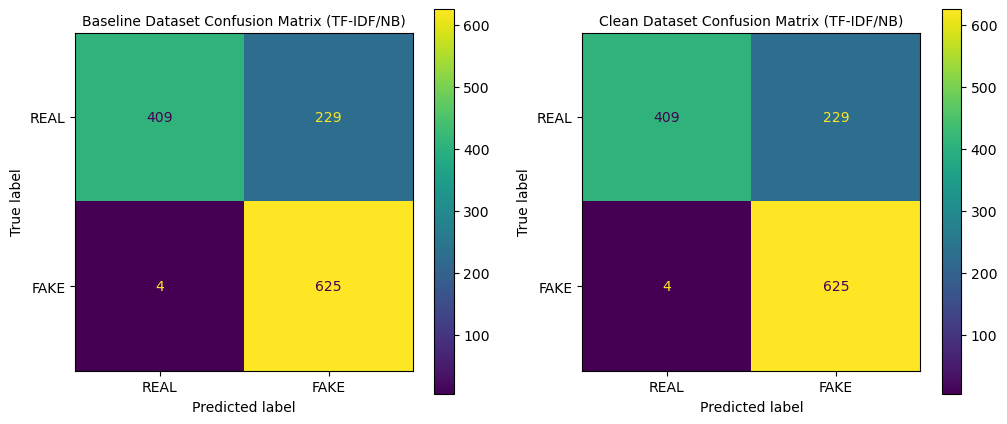

In [29]:
# Plotting subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Create the confusion matrix and display for both dataset
baseline_cm = confusion_matrix(baseline_y_test, baseline_y_pred)
clean_cm = confusion_matrix(clean_y_test, clean_y_pred)

baseline_cm_display = ConfusionMatrixDisplay(baseline_cm, display_labels=['REAL','FAKE'])
clean_cm_display = ConfusionMatrixDisplay(clean_cm, display_labels=['REAL','FAKE'])

# Plot the Confusion Matrices 
baseline_cm_display.plot(ax=axes[0])
clean_cm_display.plot(ax=axes[1])

axes[0].set_title('Baseline Dataset Confusion Matrix (TF-IDF/NB)', fontsize=10)
axes[1].set_title('Clean Dataset Confusion Matrix (TF-IDF/NB)', fontsize=10)

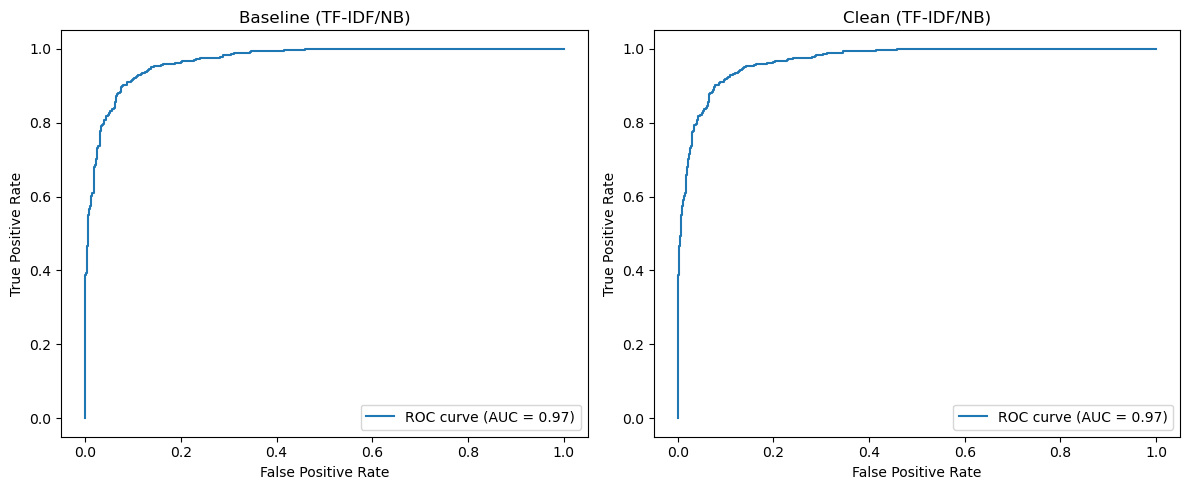

In [54]:
plt.figure(figsize=(12, 5))

baseline_fpr, baseline_tpr, _ = roc_curve(baseline_y_test, baseline_y_pred_probability, pos_label="REAL")

# Plot ROC curve for baseline
plt.subplot(1, 2, 1)
plt.plot(baseline_fpr, baseline_tpr, label=f'ROC curve (AUC = {baseline_roc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline (TF-IDF/NB)')
plt.legend(loc='lower right')

clean_fpr, clean_tpr, _ = roc_curve(baseline_y_test, baseline_y_pred_probability, pos_label="REAL")

# Plot ROC curve for clean
plt.subplot(1, 2, 2)
plt.plot(clean_fpr, clean_tpr, label=f'ROC curve (AUC = {clean_roc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Clean (TF-IDF/NB)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Conclusion

Our model, although performing weaker than weaker than the example shown in https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/ which uses PassiveAggressiveClassifier but it is close enough considering no fine tuning is done. The model performed identically on both datasets and it could be due to the nature of how TF-IDF works (words that appear across multiple documents hold lesser weight)stemming and stop word removal may not have impacted the results. 

Based on these scores, we are satisfied with the implementation and have successfully created a data pipeline. Next prototype will be built on top of this where we will implement the remaining models and feature extraction methods.